In [40]:
%%capture
!pip install langchain_core langchain langchain_community langgraph langchain-google-genai

In [ ]:
import os


os.environ["GOOGLE_API_KEY"]=google_api_key

In [42]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm=ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    temperature=0.2
)

In [43]:

LANGSMITH_API_KEY="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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = LANGSMITH_API_KEY

In [ ]:

os.environ["TAVILY_API_KEY"] = ""

In [45]:
from langgraph.graph import START, END ,StateGraph
from typing_extensions import TypedDict
from typing import List, Dict, Any,Annotated
from langgraph.graph import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import tool
from langgraph.prebuilt import ToolNode,tools_condition

class State(TypedDict):
  messages: Annotated[List[str],add_messages]

workflow=StateGraph(State)


web_tool= TavilySearchResults(max_results=2)


@tool
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

@tool
def divide_numbers(a: float, b: float) -> float:
    """Divides a by b.

    Args:
        a: The numerator.
        b: The denominator.

    Returns:
        The result of a / b.

    Raises:
        ValueError: If b is zero.
    """
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b

tools=[web_tool,divide_numbers,multiply]
llm_with_tool=llm.bind_tools(tools)
def chat(state:State)->State:
  user_messages=state['messages']
  response=llm_with_tool.invoke(user_messages)
  return ({"messages":[response]})


tool_node=ToolNode(tools)

workflow.add_node("chat",chat)
workflow.add_node("tools",tool_node)

workflow.add_edge(START,"chat")
workflow.add_conditional_edges(
    "chat",
    tools_condition
)

workflow.add_edge("tools","chat")

In [46]:

bot=workflow.compile()

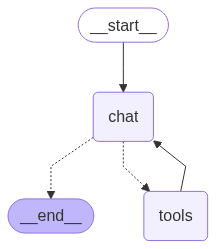

In [47]:
bot

In [21]:
user="what is the latest new about AI aand Devide 100 by 20"
res=bot.invoke({"messages":user})
res

{'messages': [HumanMessage(content='what is the latest new about AI aand Devide 100 by 20', additional_kwargs={}, response_metadata={}, id='6763de11-9ebe-4c30-b333-33ae1fa0008f'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'divide_numbers', 'arguments': '{"a": 100.0, "b": 20.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []}, id='run--4c039b9f-f497-4f14-86c0-ba59bc1574d8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest news about AI'}, 'id': '6efa6f18-b529-4222-ba89-dca14b0298a2', 'type': 'tool_call'}, {'name': 'divide_numbers', 'args': {'a': 100.0, 'b': 20.0}, 'id': '67450f7f-fe3e-4263-abc5-05cf3bdf3c67', 'type': 'tool_call'}], usage_metadata={'input_tokens': 127, 'output_tokens': 20, 'total_tokens': 147, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{"title": "AI News & Artificial I

In [22]:
for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the latest new about AI aand Devide 100 by 20
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (6efa6f18-b529-4222-ba89-dca14b0298a2)
 Call ID: 6efa6f18-b529-4222-ba89-dca14b0298a2
  Args:
    query: latest news about AI
  divide_numbers (67450f7f-fe3e-4263-abc5-05cf3bdf3c67)
 Call ID: 67450f7f-fe3e-4263-abc5-05cf3bdf3c67
  Args:
    a: 100.0
    b: 20.0
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News & Artificial Intelligence", "url": "https://techcrunch.com/category/artificial-intelligence/", "content": "Contact Us\n\n# AI\n\nNews coverage on artificial intelligence and machine learning tech, the companies building them, and the ethical issues AI raises today. This encompasses generative AI, including large language models, text-to-image 

In [48]:
user="what is the latest new about AI aand Devide 100 by 20 then multiply 5 with 10 "
res=bot.invoke({"messages":user})


In [49]:
for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the latest new about AI aand Devide 100 by 20 then multiply 5 with 10 
================================== Ai Message ==================================
Tool Calls:
  divide_numbers (2ea37855-0d10-4039-8049-2b256d80cee6)
 Call ID: 2ea37855-0d10-4039-8049-2b256d80cee6
  Args:
    a: 100.0
    b: 20.0
  multiply (db8eb1e7-3ea0-4656-867d-6debe1b9fbbb)
 Call ID: db8eb1e7-3ea0-4656-867d-6debe1b9fbbb
  Args:
    a: 5.0
    b: 10.0
  tavily_search_results_json (6458e0b6-e58d-4306-be54-574d352201ff)
 Call ID: 6458e0b6-e58d-4306-be54-574d352201ff
  Args:
    query: latest news about AI
================================= Tool Message =================================
Name: divide_numbers

5.0
================================= Tool Message =================================
Name: multiply

50
================================= Tool Message =================================
Name: tavily_search_results_json

[{"ti

In [50]:
user="what is the latest new about AI and Devide 100 by 20 then multiply 5 with 10 "
res=bot.invoke({"messages":user})
for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the latest new about AI and Devide 100 by 20 then multiply 5 with 10 
================================== Ai Message ==================================
Tool Calls:
  divide_numbers (bfab902a-e756-417d-9f54-e0353f3ba26d)
 Call ID: bfab902a-e756-417d-9f54-e0353f3ba26d
  Args:
    a: 100.0
    b: 20.0
  multiply (7e8111b6-6f32-4855-9aa8-e236100b7d57)
 Call ID: 7e8111b6-6f32-4855-9aa8-e236100b7d57
  Args:
    a: 5.0
    b: 10.0
  tavily_search_results_json (82e35511-9377-439c-a323-b263b7c54147)
 Call ID: 82e35511-9377-439c-a323-b263b7c54147
  Args:
    query: latest news about AI
================================= Tool Message =================================
Name: divide_numbers

5.0
================================= Tool Message =================================
Name: multiply

50
================================= Tool Message =================================
Name: tavily_search_results_json

[{"tit

In [51]:
complex_user_prompt = """
what is the latest new about AI then perform the following calculations:
1. Divide 100 by 20.
2. Multiply the result of the division by 10.

3. Present the final calculation result clearly at the end of your response.
"""
res = bot.invoke({"messages": complex_user_prompt})


In [52]:
for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================


what is the latest new about AI then perform the following calculations:
1. Divide 100 by 20.
2. Multiply the result of the division by 10.

3. Present the final calculation result clearly at the end of your response.

================================== Ai Message ==================================

I do not have access to real-time information, including breaking news about AI.  To get the latest news, I recommend checking reputable news sources online.


Now, let's perform the calculations:

1. **Division:**
Tool Calls:
  divide_numbers (454d0fd7-4eba-4af2-ae38-c908a05c1657)
 Call ID: 454d0fd7-4eba-4af2-ae38-c908a05c1657
  Args:
    a: 100.0
    b: 20.0
================================= Tool Message =================================
Name: divide_numbers

5.0
================================== Ai Message ==================================
Tool Calls:
  multiply (58614304-0bef-4314-a950-c167d484b540)
 Ca

In [ ]:
# In cell 38,
#  the model didn't fail to call a tool. Instead, it chose not to use the search tool for the AI news part of your prompt.
#   The AI message explicitly states that it doesn't have access to real-time information and suggests checking external news sources.
#  It then successfully used the divide_numbers and multiply tools to perform the calculations you requested.